In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

In [28]:
# read the illinois state shp data
illinois_shp = gpd.read_file('raw_il_census_tracts_shapefile/tl_2019_17_tract.shp')
illinois_shp = illinois_shp.loc[:,('GEOID','geometry')]
illinois_shp['centroid'] = illinois_shp.centroid.to_crs(epsg = 4326)
illinois_shp.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


GEOID                                           geometry  \
0  17091011700  POLYGON ((-87.88768 41.13594, -87.88764 41.136...   
1  17091011800  POLYGON ((-87.89410 41.14388, -87.89400 41.143...   
2  17119400951  POLYGON ((-90.11192 38.70281, -90.11128 38.703...   
3  17119400952  POLYGON ((-90.09442 38.72031, -90.09360 38.720...   
4  17135957500  POLYGON ((-89.70369 39.34803, -89.69928 39.348...   

                     centroid  
0  POINT (-87.87355 41.12949)  
1  POINT (-87.87646 41.13978)  
2  POINT (-90.09829 38.72763)  
3  POINT (-90.08180 38.72984)  
4  POINT (-89.60391 39.38915)

In [47]:
def riskDF_risklineGDF(risk_flow_df_path):
    risk_flows_df = pd.read_csv(risk_flow_df_path).loc[:,('START','END','RISK_FLOW')]
    risk_flows_df['START'] = risk_flows_df['START'].astype(str)
    risk_flows_df['END'] = risk_flows_df['END'].astype(str)

    start_geo_df = pd.merge(risk_flows_df, illinois_shp, how='left', left_on='START', right_on='GEOID')
    start_geo_df = start_geo_df[['START', 'END', 'RISK_FLOW', 'centroid']]
    start_geo_df = start_geo_df.rename(columns = {'centroid' : 'START_centroid'})

    end_geo_df = pd.merge(start_geo_df, illinois_shp, how='left', left_on='END', right_on='GEOID')
    end_geo_df = end_geo_df[['START', 'END', 'RISK_FLOW', 'START_centroid', 'centroid']]
    end_geo_df = end_geo_df.rename(columns = {'centroid' : 'END_centroid'})

    geo_line_df = end_geo_df
    geo_line_df['FLOWLINES'] = pd.DataFrame([LineString([end_geo_df.loc[i, 'START_centroid'],
                                                     end_geo_df.loc[i, 'END_centroid']]) 
                                         for i in range(len(end_geo_df))])

    geo_risk_line_df = geo_line_df[['RISK_FLOW', 'FLOWLINES']]
    geo_risk_line_df.columns = ['RISK_FLOW','geometry']
    geo_risk_line_df['RISK_FLOW'] = geo_risk_line_df['RISK_FLOW']
    mean_risk = np.mean(geo_risk_line_df['RISK_FLOW'])
    geo_risk_line_df = geo_risk_line_df[geo_risk_line_df['RISK_FLOW']> mean_risk]

    geo_risk_line_gdf = gpd.GeoDataFrame(geo_risk_line_df)
    return geo_risk_line_gdf

In [51]:
def drawRiskflows(geo_risk_line_gdf, png_path):
    base_map = illinois_shp.plot(color='white', 
                       edgecolor='black', 
                       alpha = 0.1, 
                       figsize = (9,12))

    risk_flow_map = geo_risk_line_gdf.plot(ax = base_map, 
                    column = 'RISK_FLOW', 
                    cmap='Reds', 
                    scheme = 'percentiles',
                   legend=True,
                    markersize = 'RISK_FLOW', 
                    figsize = (5,4))

    # Adjust legend location
    leg = risk_flow_map.get_legend()
    leg.set_bbox_to_anchor((0.25,0.25))

    risk_flow_map.axis('off')
    plt.savefig(png_path, dpi = 200)

---

In [22]:
geo_risk_line1_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/risk/riskflow1_df.csv')
geo_risk_line2_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/risk/riskflow2_df.csv')
geo_risk_line3_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/risk/riskflow3_df.csv')
geo_risk_line4_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/risk/riskflow4_df.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


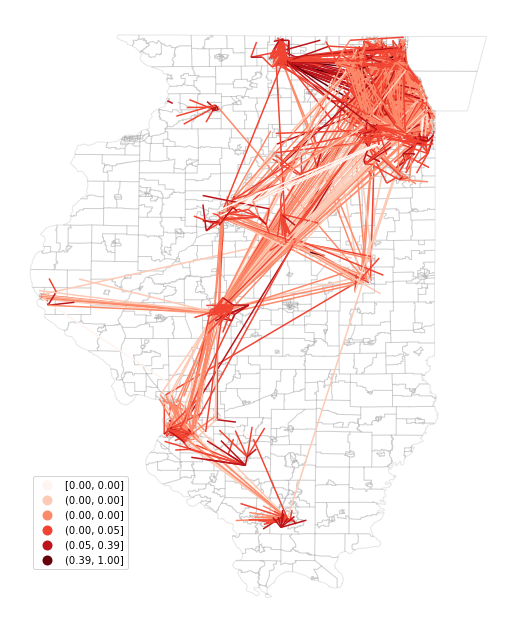

In [23]:
drawRiskflows(geo_risk_line_gdf = geo_risk_line1_gdf,
              png_path = 'Streetlight_Data/clean_data/risk_flows_map1.png')

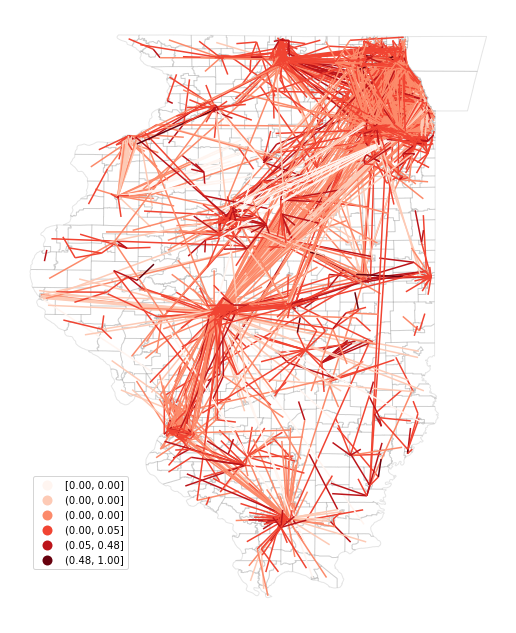

In [24]:
drawRiskflows(geo_risk_line_gdf = geo_risk_line2_gdf,
              png_path = 'Streetlight_Data/clean_data/risk_flows_map2.png')

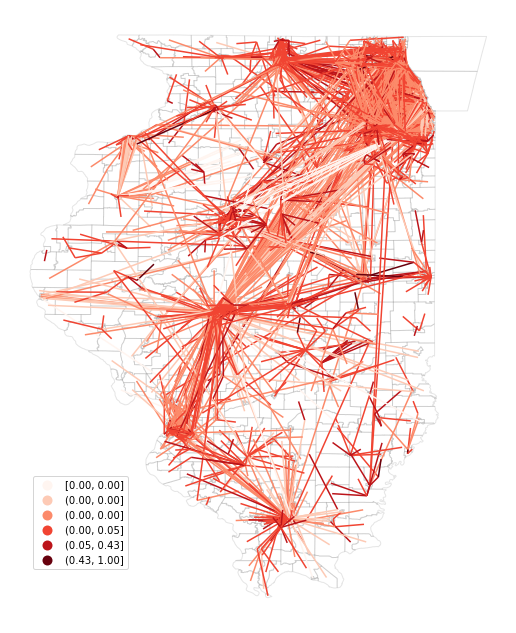

In [25]:
drawRiskflows(geo_risk_line_gdf = geo_risk_line3_gdf,
              png_path = 'Streetlight_Data/clean_data/risk_flows_map3.png')

In [26]:
drawRiskflows(geo_risk_line_gdf = geo_risk_line4_gdf,
              png_path = 'Streetlight_Data/clean_data/risk_flows_map4.png')

---

In [49]:
geo_unor_risk_line1_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/unnorm/unor_riskflow1_df.csv')
geo_unor_risk_line2_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/unnorm/unor_riskflow2_df.csv')
geo_unor_risk_line3_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/unnorm/unor_riskflow3_df.csv')
geo_unor_risk_line4_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/unnorm/unor_riskflow4_df.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [52]:
drawRiskflows(geo_risk_line_gdf = geo_unor_risk_line1_gdf,
              png_path = 'Streetlight_Data/clean_data/unnorm/risk_flows_map1.png')

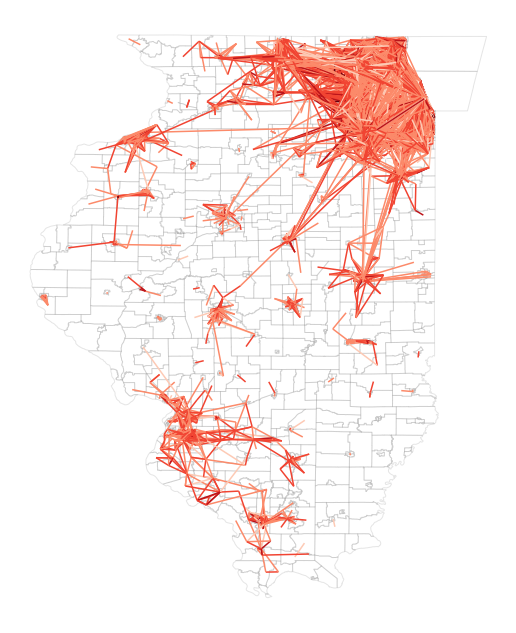

In [44]:
drawRiskflows(geo_risk_line_gdf = geo_unor_risk_line2_gdf,
              png_path = 'Streetlight_Data/clean_data/unnorm/risk_flows_map2.png')

In [45]:
drawRiskflows(geo_risk_line_gdf = geo_unor_risk_line3_gdf,
              png_path = 'Streetlight_Data/clean_data/unnorm/risk_flows_map3.png')

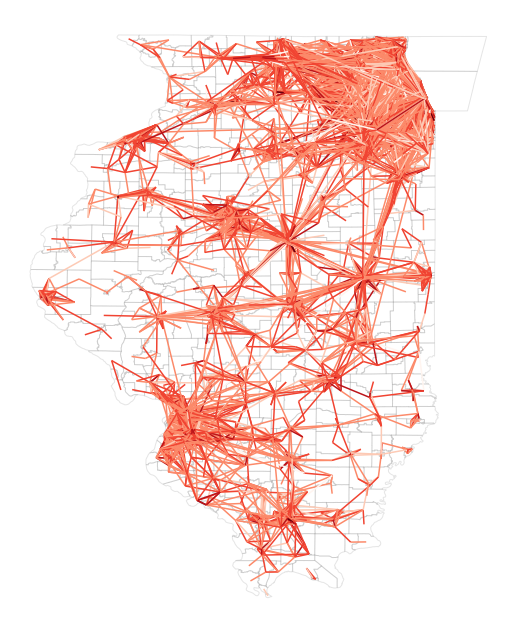

In [46]:
drawRiskflows(geo_risk_line_gdf = geo_unor_risk_line4_gdf,
              png_path = 'Streetlight_Data/clean_data/unnorm/risk_flows_map4.png')

In [15]:
geo_dptotal_risk_line1_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/dptotal/dptotal_riskflow1_df.csv')
geo_dptotal_risk_line2_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/dptotal/dptotal_riskflow2_df.csv')
geo_dptotal_risk_line3_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/dptotal/dptotal_riskflow3_df.csv')
geo_dptotal_risk_line4_gdf = riskDF_risklineGDF(risk_flow_df_path = 'Streetlight_Data/clean_data/dptotal/dptotal_riskflow4_df.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

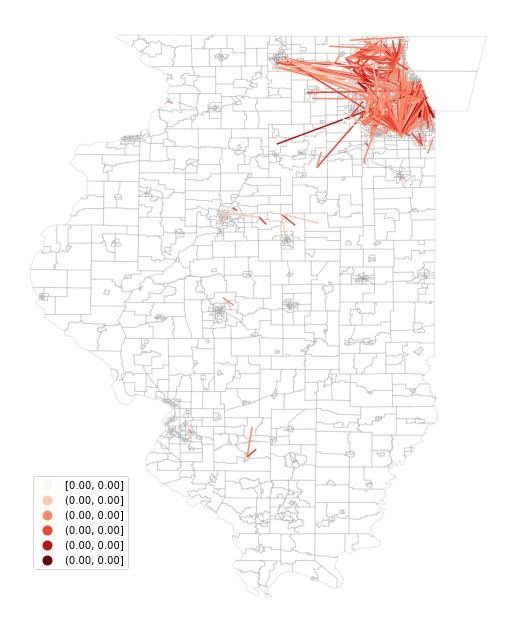

In [16]:
drawRiskflows(geo_risk_line_gdf = geo_dptotal_risk_line1_gdf,
              png_path = 'Streetlight_Data/clean_data/dptotal/risk_flows_map1.png')

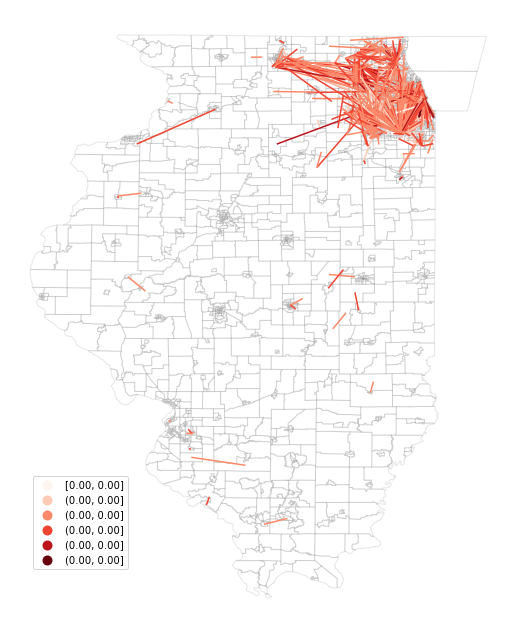

In [17]:
drawRiskflows(geo_risk_line_gdf = geo_dptotal_risk_line2_gdf,
              png_path = 'Streetlight_Data/clean_data/dptotal/risk_flows_map2.png')

In [18]:
drawRiskflows(geo_risk_line_gdf = geo_dptotal_risk_line3_gdf,
              png_path = 'Streetlight_Data/clean_data/dptotal/risk_flows_map3.png')

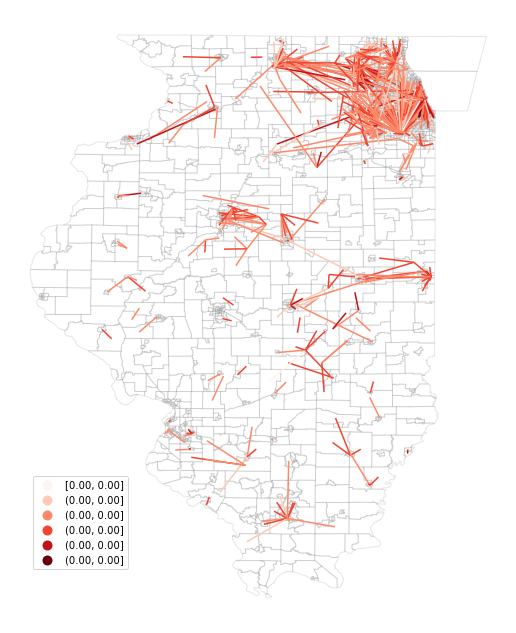

In [19]:
drawRiskflows(geo_risk_line_gdf = geo_dptotal_risk_line4_gdf,
              png_path = 'Streetlight_Data/clean_data/dptotal/risk_flows_map4.png')